In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
from joblib import Parallel, delayed

In [2]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.neighbors import KNeighborsClassifier

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Import Data

In [4]:
data_path = '../data/facebook/facebook_combined.txt'
graph = nx.read_edgelist(data_path)

print(f'Graph with {len(graph.nodes)} nodes and {len(graph.edges)} edges was correctly loaded')

Graph with 4039 nodes and 88234 edges was correctly loaded


# Network characteristics

In [5]:
print('Graph main characteristics :')

print(f'Nodes : {len(graph.nodes)}')
print(f'Edges : {len(graph.edges)}')
print(f'Diameter : {nx.diameter(graph)}')

Graph main characteristics :
Nodes : 4039
Edges : 88234
Diameter : 8


# Metrics

In [6]:
metrics_to_functions = {
    'degree': lambda graph : graph.degree, 
    'eigenvector_centrality': nx.eigenvector_centrality, 
    'page_rank': nx.pagerank,
    'clustering_coef': nx.clustering, 
    'closeness': nx.closeness_centrality, 
    'betweenness' : nx.betweenness_centrality
    }
## neighborhood_connectivity missing

def compute_centrality(metric, graph):
    print(f'Metric {metric} is being measured')
    return {metric: metrics_to_functions[metric](graph)}

def get_centralities(graph, metrics_to_functions):
    metric_list = Parallel(n_jobs=4)(delayed(compute_centrality)(metric, graph) for metric in metrics_to_functions.keys())
    metric_dict = {}
    for item in metric_list:
        key = list(item.keys())[0]
        metric_dict[key] = dict(item[key])
    return metric_dict

In [7]:
graph_metrics = get_centralities(graph, metrics_to_functions)

In [8]:
print(graph_metrics.keys())

dict_keys(['degree', 'eigenvector_centrality', 'page_rank', 'clustering_coef', 'closeness', 'betweenness'])


In [9]:
def get_n_maxima_for_metric(n, metric, graph_metrics) :
    temp = graph_metrics[metric].copy()
    max_keys = []
    for i in range(n):
        key = max(temp, key=temp.get)
        max_keys.append(key)
        temp[key] = 0
    return max_keys

max_degree_nodes = get_n_maxima_for_metric(10, "degree", graph_metrics)
max_eigenvector_centrality_nodes = get_n_maxima_for_metric(10, "eigenvector_centrality", graph_metrics)
max_page_rank_nodes = get_n_maxima_for_metric(10, "page_rank", graph_metrics)
max_clustering_coef_nodes = get_n_maxima_for_metric(10, "clustering_coef", graph_metrics)
max_closeness_nodes = get_n_maxima_for_metric(10, "closeness", graph_metrics)
max_betweenness_nodes = get_n_maxima_for_metric(10, "betweenness", graph_metrics)

print(f"Maximum degree nodes : {max_degree_nodes}")
print(f"Maximum eigenvector_centrality nodes : {max_eigenvector_centrality_nodes}")
print(f"Maximum page_rank nodes : {max_page_rank_nodes}")
print(f"Maximum clustering_coef nodes : {max_clustering_coef_nodes}")
print(f"Maximum closeness nodes : {max_closeness_nodes}")
print(f"Maximum betweenness nodes : {max_betweenness_nodes}")

Maximum degree nodes : ['107', '1684', '1912', '3437', '0', '2543', '2347', '1888', '1800', '1663']
Maximum eigenvector_centrality nodes : ['1912', '2266', '2206', '2233', '2464', '2142', '2218', '2078', '2123', '1993']
Maximum page_rank nodes : ['3437', '107', '1684', '0', '1912', '348', '686', '3980', '414', '698']
Maximum clustering_coef nodes : ['32', '33', '35', '42', '44', '46', '47', '52', '63', '70']
Maximum closeness nodes : ['107', '58', '428', '563', '1684', '171', '348', '483', '414', '376']
Maximum betweenness nodes : ['107', '1684', '3437', '1912', '1085', '0', '698', '567', '58', '428']


# Propagation d'une rumeur

In [52]:
def plot_history(history, n_labels):    

    n_labels = 2

    epochs = [epoch for epoch in range(len(history))]
    label_names = [f"{i}" for i in range(n_labels)]
    colors = ['#FF5733', '#33FF7A', '#336BFF']

    data = np.zeros((len(label_names), len(epochs)))
    for epoch, hist in enumerate(history):
        for label in hist.keys():
            data[label, epoch] = hist[label]

    fig, ax = plt.subplots(figsize=(15, 7))

    bottom = np.zeros(len(epochs))
    for i in range(len(label_names)):
        ax.bar(epochs, data[i], width=0.4, color=colors[i%len(colors)], align='center', label=label_names[i], bottom=bottom)
        bottom += data[i]

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Nombre de noeux pour chaque label')
    ax.set_title('Évolution du nombre de label au cours de la propagation')
    ax.legend(loc='best')

    return fig, ax

## 1. Par random walk

In [49]:
def label_propagation_rw(graph, labeled_nodes, max_iter=10):
    """
    Label propagation using the random walk method.
    """
    # Create a dictionary of node indices to their corresponding row indices in the transition matrix.
    node_to_row = {n: i for i, n in enumerate(graph.nodes())}

    # Create transition matrix
    adjacency_matrix = nx.to_numpy_array(graph)
    row_sums = adjacency_matrix.sum(axis=1)
    transition_matrix = adjacency_matrix / row_sums[:, np.newaxis]

    # Initialize the label matrix and a mask
    Y = np.zeros((len(graph.nodes()), len(labeled_nodes)))
    mask = np.ones((len(graph.nodes()), len(labeled_nodes))) * False
    for label, nodes in labeled_nodes.items():
        for node in nodes:
            # One hot encode each label
            Y[node_to_row[node], label] = 1
            mask[node_to_row[node]] = True
    
    # Initialize history and load initial situation
    history = []
    epoch_hist = {}
    for label in labeled_nodes.keys():
        epoch_hist[label] = 0
    for node in graph.nodes():
            if np.sum(Y[node_to_row[node]]) != 0:
                epoch_hist[np.argmax(Y[node_to_row[node]])] += 1
    history.append(epoch_hist)

    # Propagate the labels using the transition matrix.
    for i in range(max_iter):
        # Iterate Y
        Y_new = transition_matrix.dot(Y)
        if np.allclose(Y, Y_new):
            break
        Y = Y_new * (1 - mask) + Y * (mask)
        # Store number of nodes of each class
        epoch_hist = {}
        for label in labeled_nodes.keys():
            epoch_hist[label] = 0
        for node in graph.nodes():
                epoch_hist[np.argmax(Y[node_to_row[node]])] += 1
        history.append(epoch_hist)

    # Create a dictionary of node indices to their labels.
    labels = {node: np.argmax(Y[node_to_row[node]]) for node in graph.nodes()}

    return labels, history

In [50]:
labels, history = label_propagation_rw(
    graph, 
    {0: np.array(max_eigenvector_centrality_nodes)[0], 1: np.array(max_eigenvector_centrality_nodes)[1:]},
    max_iter=100
    )

In [51]:
for epoch, hist in enumerate(history):
    if epoch % 10 == 0:
        print(f"Epoch {epoch} : {hist}")

Epoch 0 : {0: 3, 1: 9}
Epoch 10 : {0: 1394, 1: 2645}
Epoch 20 : {0: 1302, 1: 2737}
Epoch 30 : {0: 1002, 1: 3037}
Epoch 40 : {0: 792, 1: 3247}
Epoch 50 : {0: 767, 1: 3272}
Epoch 60 : {0: 691, 1: 3348}
Epoch 70 : {0: 431, 1: 3608}
Epoch 80 : {0: 407, 1: 3632}
Epoch 90 : {0: 375, 1: 3664}
Epoch 100 : {0: 374, 1: 3665}


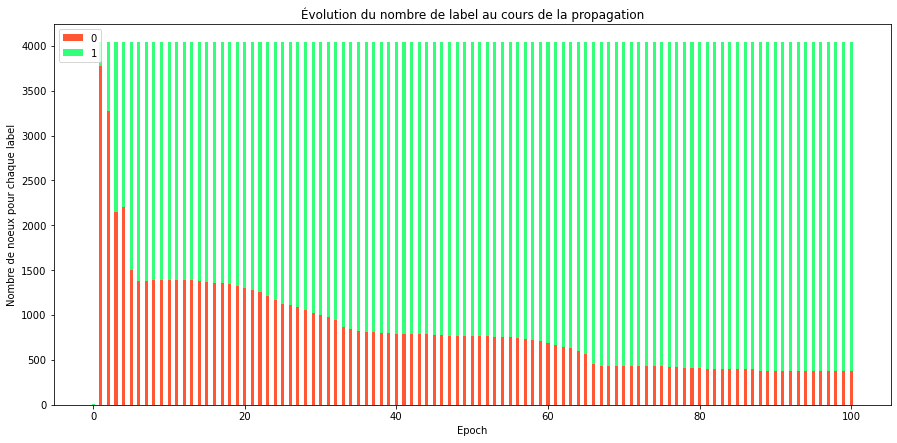

In [53]:
fig, ax = plot_history(history, n_labels=2)
plt.show()

## 2. Par Supervised learning avec la fonction LabelPropagation

In [54]:
def label_propagation_lp(graph, graph_metrics, labeled_nodes):
    """
    Label propagation using a supervised learning approach.
    """
    # Create a dictionary of node indices to their corresponding row indices in the transition matrix.
    node_to_row = {n: i for i, n in enumerate(graph.nodes())}

    # Create the feature matrix X and label vector y.
    X = np.array([[graph_metrics[metric][node]  for metric in graph_metrics.keys()] for node in graph.nodes()])
    y = np.ones((len(graph.nodes()))) * (-1)
    for label, nodes in labeled_nodes.items():
        for node in nodes:
            y[node_to_row[node]] = label

    # Création du modèle de propagation de label
    model = LabelPropagation(kernel='knn')

    # Exécution de l'algorithme de propagation de label
    model.fit(X, y)

    # Récupération des labels résultants
    labels = model.transduction_

    return labels, _

In [57]:
labels, history = label_propagation_lp(
    graph,
    graph_metrics, 
    {0: np.array(max_eigenvector_centrality_nodes)[:1], 1: np.array(max_eigenvector_centrality_nodes)[1:]},
    )

In [58]:
print(f"0: {np.sum(labels == 0)}, 1: {np.sum(labels == 1)}")

0: 3915, 1: 124


## 2. Par Supervised learning avec un KNN à la main

In [95]:
def label_propagation_knn(graph, graph_metrics, labeled_nodes, max_iter=10):
    """
    Label propagation using a supervised learning approach.
    """
    # Create a dictionary of node indices to their corresponding row indices in the transition matrix.
    node_to_row = {n: i for i, n in enumerate(graph.nodes())}

    # Create the feature matrix X and label vector y and mask
    X = np.array([[graph_metrics[metric][node]  for metric in graph_metrics.keys()] for node in graph.nodes()])
    y = np.zeros((len(graph.nodes()), len(labeled_nodes)))
    mask_X = np.zeros((len(graph.nodes())), dtype=bool)
    mask_y = np.zeros((len(graph.nodes())), dtype=bool)
    for label, nodes in labeled_nodes.items():
        for node in nodes:
            y[node_to_row[node], label] = 1
            mask_X[node_to_row[node]] = True
            mask_y[node_to_row[node]] = True

    # Initialize history and load initial situation
    history = []
    epoch_hist = {}
    for label in labeled_nodes.keys():
        epoch_hist[label] = 0
    for node in graph.nodes():
            if np.sum(y[node_to_row[node]]) != 0:
                epoch_hist[np.argmax(y[node_to_row[node]])] += 1
    history.append(epoch_hist)

    # First learning iteration is specific so we do it outside the loop
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X[mask_X], y[mask_y])
    y = model.predict(X) * ~np.transpose(np.array([mask_y, mask_y])) + y * np.transpose(np.array([mask_y, mask_y]))

    # Propagate the labels using the label propagation algorithm.
    for i in range(1, max_iter):
        model = KNeighborsClassifier(n_neighbors=5)
        model.fit(X, y)
        y_new = model.predict(X)
        #create a mask for neighbours
        neighbors = np.zeros((len(graph.nodes())), dtype=bool)
        for node in graph.nodes:
            if np.sum(y[node_to_row[node]]) == 1:
                for n in graph.neighbors(node):
                    neighbors[node_to_row[n]] = True
        if np.allclose(y, y_new):
            break
        nodes_to_update = neighbors * ~mask_y
        y = y_new * np.transpose(np.array([nodes_to_update, nodes_to_update])) + y * np.transpose(np.array([mask_y, mask_y]))
        print(np.sum(y))
        # Store number of nodes of each class
        epoch_hist = {}
        for label in labeled_nodes.keys():
            epoch_hist[label] = 0
        for node in graph.nodes():
                epoch_hist[np.argmax(y[node_to_row[node]])] += 1
        history.append(epoch_hist)

    # Create a dictionary of node indices to their labels.
    labels = {node: np.argmax(y[node_to_row[node]]) for node in graph.nodes()}

    return labels, history

In [96]:
labels, history = label_propagation_knn(
    graph,
    graph_metrics, 
    {0: np.array(max_eigenvector_centrality_nodes)[:2], 1: np.array(max_eigenvector_centrality_nodes)[3:]},
    )

4039.0
4039.0
4039.0
4039.0
4039.0
4039.0
4039.0
4039.0
4039.0


In [97]:
for epoch, hist in enumerate(history):
    #if epoch % 10 == 0:
    if epoch < 10:
        print(f"Epoch {epoch} : {hist}")

Epoch 0 : {0: 2, 1: 7}
Epoch 1 : {0: 2, 1: 4037}
Epoch 2 : {0: 2, 1: 4037}
Epoch 3 : {0: 2, 1: 4037}
Epoch 4 : {0: 2, 1: 4037}
Epoch 5 : {0: 2, 1: 4037}
Epoch 6 : {0: 2, 1: 4037}
Epoch 7 : {0: 2, 1: 4037}
Epoch 8 : {0: 2, 1: 4037}
Epoch 9 : {0: 2, 1: 4037}


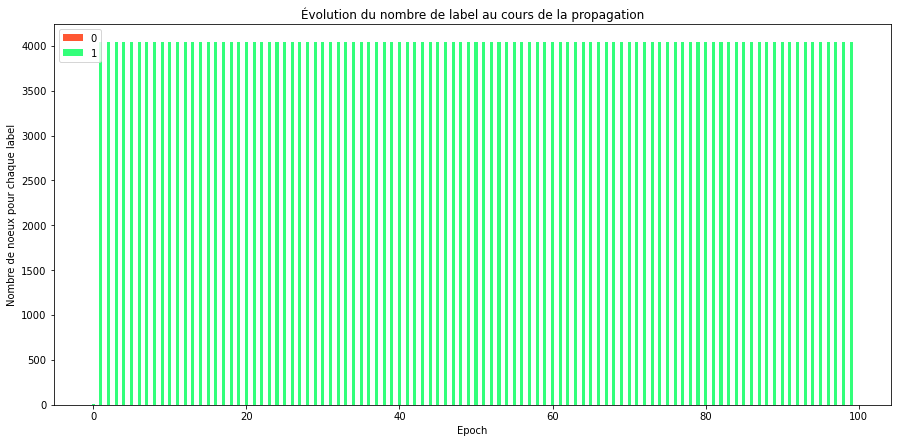

In [23]:
fig, ax = plot_history(history, n_labels=2)
plt.show()